# Bagian C
---
**Persiapan Eksperimen**

Anggota : 
- Jovan Karuna Cahyadi (13518024)
- Ricky Fernando (13518062)
- Stefanus Stanley Yoga Setiawan (13518122)
- William (13518138)

# External Library & Notebook Sanity Check
---
Berikut library eksternal yang kami gunakan :
- numpy
- pandas



In [ ]:
import pandas as pd
import math
import numpy as np
import json
import matplotlib.pyplot as plt

from copy import deepcopy
from json import JSONEncoder
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# Utility Function

---
Terdapat beberapa fungsi _utility_ yang kami buat untuk mempermudah tahapan pembangunan Neural Network, sebagai berikut:

Sementara itu, fungsi - fungsi _activation_ yang telah dibuat pada bagian A sebelumnya diubah agar dapat menghitung nilai derivasi fungsi, yaitu:




In [ ]:
###################
# Model Selection #
###################
def one_hot_encoder(y):
  b = np.zeros((y.size, y.max()+1))
  b[np.arange(y.size),y] = 1
  return b
  
#################
# Loss Function #
#################

def mse(y_pred, y, derivative=False):
  if derivative:
    return -1*(y-y_pred)
  return 0.5*(y-y_pred)**2

def cross_entropy(y_pred, y):
  n_data = len(y[0])
  res = []
  for i in range(n_data):
    target = y[:, i]
    target_index = np.where(target==1)[0][0]
    err = -np.log10(y_pred[:, i][target_index])
    res.append(err)
  return np.array(res)

#######################
# Activation Function #
#######################

def relu(x, derivative=False):
  if derivative:
    return 1
  return np.maximum(0, x)

def linear(x, derivative=False):
  if derivative:
    return 1
  return x

def sigmoid(x, derivative=False):
  if derivative:
    return x*(1-x)
  return 1/(1+np.exp(-x))

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(res, y):
  lists=[]
  n_data = len(y[0])
  res_copy = deepcopy(res)
  y_copy = deepcopy(y)
  y_transpose = y_copy.T
  res_transpose = res_copy.T
  for i in range(n_data):
    target = list(y_transpose[i])
    target_index = target.index(1)
    res_transpose[i][target_index] = -(1-res_transpose[i][target_index])
  return res_transpose.T 

####################
# Scoring Function #
####################

from sklearn.model_selection import KFold, StratifiedKFold

def cross_validation(x, y, model, learning_rate=0.1, loss=cross_entropy, 
                     batch_size=5, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=False)
    scores = []
    best_score = -1
    best_model = None
    for train_index, test_index in kf.split(x):
      copy_model = deepcopy(model)
      X_train, X_test = x[train_index], x[test_index]
      y_train, y_test = y[train_index], y[test_index]

      copy_model.compile(X_train, y_train, learning_rate=learning_rate, 
                         loss=loss, batch_size=batch_size)
      copy_model.train(epochs=50)

      y_pred = copy_model.predict(X_test)
      score = accuracy_score(y_pred, y_test)
      
      if score >= best_score :
        best_model = deepcopy(copy_model)
        best_score = score
      
      scores.append(score)
      
    return {
        "score" : scores,
        "best_model" : best_model
    }

def confusion_matrix(y_pred, y_test):
    isOneHot = len(y_pred[0]) == 1
    
    if not isOneHot:
        ret = [[0 for i in range(len(y_pred[0]))] for i in range(len(y_pred[0]))]
        pred, truth = y_pred.argmax(1), y_test.argmax(1)
        for a, b in zip(pred, truth):
            ret[a][b] += 1
    else:
        ret = [[0,0], [0,0]]
        for a, b in zip(y_pred, y_test):
            pred, truth = int(np.round(a)), int(np.round(b))
            ret[pred][truth] += 1
    return np.array(ret)



def accuracy_score(y_pred, y_test):
  isOneHot = len(y_pred[0]) == 1
  if not isOneHot:
    t_y_pred = np.zeros_like(deepcopy(y_pred))
    t_y_pred[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
    count = 0
    total = len(t_y_pred)
    for i in range(total):
      if (not np.array_equal(t_y_pred[i], y_test[i])):
        count += 1
    return 1 - count/total
  else:
    count = 0
    total = y_pred.shape[0]
    for a, b in zip(y_pred, y_test):
      if np.round(a) == np.round(b):
        count += 1
    return count/total

def precision_score(y_pred, y_test):
  conf = np.transpose(confusion_matrix(y_pred, y_test))
  precision = []
  for i in range(conf.shape[0]):
    precision.append(conf[i][i]/sum(conf[i]))
  return np.array(precision)
   
def recall_score(y_pred, y_test):
  conf = confusion_matrix(y_pred, y_test)
  recall = []
  for i in range(conf.shape[0]):
    recall.append(conf[i][i]/sum(conf[i]))
  return np.array(recall)

def f1_score(y_pred, y_test):
  precision = precision_score(y_pred, y_test)
  recall = recall_score(y_pred, y_test)
  f1 = []
  for i in range(precision.shape[0]):
    f1.append(2*((precision[i]*recall[i])/(precision[i]+recall[i])))
  return np.array(f1)

def classification_report(y_pred, y_test):
  precision = precision_score(y_pred, y_test)
  recall = recall_score(y_pred, y_test)
  f1 = f1_score(y_pred, y_test)
  df = pd.DataFrame(np.round(np.transpose([precision, recall, f1]), 3),
                   columns=['precision', 'recall', 'f1-score'])
  return df

#######################
# External File Utils #
#######################
def export_to_json(data, filename):
  
  class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

  with open(filename, "w") as json_file:  
    json.dump(data, json_file, cls=NumpyArrayEncoder) 
  

def import_from_json(filename):
  with open(filename, 'r') as json_file: 
    data = json.load(json_file)
  if data is not None : 
    return data
  else :
    print("No data found!")

def activation_func_identifier(func_name):
  return {
    "sigmoid" : sigmoid,
    "softmax" : softmax,
    "linear" : linear,
    "relu" : relu
  }.get(func_name)

def activation_func_dump(func):
  return {
    sigmoid : "sigmoid",
    softmax : "softmax",
    linear : "linear",
    relu : "relu"
  }.get(func)

def create_history(ann):
  for i, hist in enumerate(ann.history):
    if i == 0:
      print('Input Layer')
    else:
      print(f'Layer {i}')
    for j, value in enumerate(hist):
      if i == 0:
        print(f'    Features {j} = {value}')
      else:
        print(f'    σ(Out Nodes {j}) = {value}')

# Artificial Neural Network Representation

In [ ]:
class HiddenLayer():
  """
  Attributes:
    weights (np.array) -> with shape (n_nodes, n_features)
      weights[nodes][features]
    prev_res (np.array) -> with shape (n_features, n_data)
      prev_res[features][n]
    out (np.array) -> with shape (n_nodes, n_data)
    bias (np.array) -> with shape (n_nodes)
    activation_function (function) -> activation function for this layer
  
  Method:
    calculate_out -> dot product between input and nodes weight
  """
  def __init__(self, nodes, activation_function, prev_res=None):
    """
    Parameters:
      nodes (tuple(int, int)) -> Create matrix weights
      activation_function (function) -> activation function for this layer
      prev_res (np.array) -> with shape (n_nodes_before, n_data), first layer
      shape is (n_features, n_data), next layer will be initialize with None
      because no output yet from nodes before
    """
    self.weights = np.random.uniform(0, 1, nodes)
    self.out = None
    self.prev_res = prev_res
    self.bias = np.random.uniform(0, 1, (1, self.weights.shape[0]))
    self.activation_function = activation_function

  def calculate_out(self, prev_res):
    """
    Calculate dot product between weights and inputs
    Formula:
      activation(Weights . value_before + bias)

    Parameters:
      prev_res (np.array) -> Input given to layer
    """
    self.prev_res = prev_res
    mult = self.weights @ self.prev_res
    for i in range(self.weights.shape[0]):
      mult[i] += self.bias[0][i]
    self.out = self.activation_function(mult)

  def __str__(self):
    return f'{self.weights}'

In [ ]:
class BuildError(Exception):
  """
  Exception when build ANN
  """
  def __init__(self, message):
    super().__init__(message)

In [ ]:
class ANNClassifier():
  """
  Attributes:
    x (np.array) -> with shape (n_features, n_data)
    y (np.array) -> with shape (n_data, n_class or 1)
    learning_rate (float) -> learning_rate for training
    metrics (function) -> metrics for evaluation
    verbose (int) -> output message training every epoch
    layers (list(HiddenLayer)) -> last layer is output layer
    loss_hist (list(float)) -> loss history 
    score_hist (list(float)) -> score history
    history (list(float)) -> input from every layer
    
  Method:
    __feed_forward -> feed forward in ANN
    __back_propagation -> back propagation in ANN
    __create_batch -> create mini batch data
    add -> insert layer to ANN
    compile -> compile model
    train -> train model
    predict -> predict data
    save -> saving model
    load -> loading model
    plot_loss -> plotting loss in train
    plot_score -> plotting score in train
  """
  def __init__(self, verbose=1):
    self.verbose = verbose
    self.layers = []
    self.history = []
    self.score_hist = []
    self.conf_hist = []
    self.loss_hist = []
    
    self.score_hist_batch = []
    self.conf_hist_batch = []
    self.loss_hist_batch = []
    

  def __feed_forward(self, batch):
    """
    Feed Forward method used in ANN which calculate input and produce output
    using dot product in every layer

    Parameters:
      batch (np.array) -> Used data

    Formula:
      res[0] = input
      res[1] = activation(Weights[0] . res[0] + bias[0])
      res[2] = activation(Weights[1] . res[1] + bias[1])
      .
      ..
      ...
      res[n] = activation(Weights[n-1] . res[n-1] + bias[n-1])
      output = activation(Weights[n] . res[n] + bias[n])
    """
    self.layers[0].prev_res = batch[0]
    prev_res = self.layers[0].prev_res
    for layer in self.layers:
      layer.calculate_out(prev_res)
      prev_res = layer.out
  
  def __back_propagation(self, batch):
    """
    Backpropagation method
    Step:
      1. Calculate dE/dOut (error'(output layer))
      2. Calculate dOut/dNet (activation'(output layer))
      3. Calculate dNet/dW (input layer)
      4. Calculate multiplication from dEdOut and dOutdNet
      5. Calculate mult by multiply dEdOut with dOutdNet. If not last layer,
         need to times mult before with dOutdNet and dot product it with
         transpose previous layer weights
      6. Find step using dot product between mult and transpose dNetdW (nabla)
      7. Updating weight
      8. Repeat until all weights updated
    """
    prev_layer = deepcopy(self.layers[-1])

    if (activation_func_dump(self.layers[-1].activation_function) == "softmax"):
      dEdNet = softmax_derivative(self.layers[-1].out, batch[1].T)
      mult = dEdNet
    else:
      dEdOut = self.loss(self.layers[-1].out, batch[1].T, derivative=True)
      dOutdNet = self.layers[-1].activation_function(
          self.layers[-1].out, derivative=True)
      mult = dEdOut * dOutdNet

    dNetdW = self.layers[-1].prev_res
    nabla = mult @ dNetdW.T
    self.layers[-1].weights -= self.learning_rate * nabla

    # bias
    x = np.matrix([[1] * self.layers[-1].bias.shape[0]] * self.layers[-1].prev_res.shape[1])
    nabla_bias = mult @ x
    self.layers[-1].bias -= self.learning_rate * nabla_bias.T
    
    for layer in np.flip(self.layers)[1:]:
      dOutdNet = layer.activation_function(layer.out, derivative=True)
      mult = prev_layer.weights.T @ mult * dOutdNet
      dNetdW = layer.prev_res
      nabla = mult @ dNetdW.T
      prev_layer = deepcopy(layer)
      layer.weights -= self.learning_rate * nabla

      # Update bias
      x = np.matrix([[1] * layer.bias.shape[0]] * layer.prev_res.shape[1])
      nabla_bias = mult @ x
      layer.bias -= self.learning_rate * nabla_bias.T
    
  def __create_batch(self):
    """
    Create mini batch data as many as batch size

    Return:
      batches -> mini batch after splitting
    """
    batches = []
    data = self.x.T
    n_data = data.shape[0]
    n_batch = n_data // self.batch_size
    total = 0

    for i in range(self.batch_size):
      start = n_batch * i
      if i == self.batch_size - 1:
        mini_batch = (data[start:].T, self.y[start:])
      else:
        end = start + n_batch
        mini_batch = (data[start:end].T, self.y[start:end])
        total += end-start
      batches.append(mini_batch)
    
    return batches

  def compile(self, 
              x, 
              y, 
              learning_rate=0.1, 
              metrics=accuracy_score, 
              loss=mse,
              batch_size=16):
    """
    Compiling model before training

    Parameters:
      x (np.array) -> input data with shape (n_features, n_data)
      y (np.array) -> target input with shape (n_data, n_class or 1)
      learning_rate (int) -> learning rate used for training
      metrics (function) -> metrics used to evaluate model performance
      loss (function) -> error function for training and evaluate model 
                         performance
      batch_size (int) -> batch used every training
    
    Throws:
      BuildError -> batch size > data size
    """
    if batch_size > x.shape[0]:
      raise BuildError("Input Batch Size should be < data size")
    if (activation_func_dump(self.layers[-1].activation_function) == 'softmax')\
     and (loss != cross_entropy):
      raise BuildError("Softmax output layer must use cross entropy loss function")

    self.x = x.T
    self.y = y
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.loss = loss
    self.batch_size = batch_size

  def train(self, epochs=5, error_threshold = 0.0001):
    """
    Training model
    Step:
      1. Splitting batch
      2. Feed Forward
      3. Back Propagation (Including updating weight)
    """
    self.epochs = epochs
    batches = self.__create_batch()

    for _ in range(epochs):
      for batch in batches:
        self.__feed_forward(batch)

        out = self.layers[-1].out.T
        error = np.sum(self.loss(out.T, batch[1].T))
        score = self.metrics(out, batch[1])
        conf = confusion_matrix(out, batch[1])
        self.loss_hist_batch.append(error)
        self.score_hist_batch.append(score)
        self.conf_hist_batch.append(conf)

        self.__back_propagation(batch)

      out = self.predict(self.x, trained=True)
      error = np.sum(self.loss(out.T, self.y.T))
      score = self.metrics(out, self.y)
      conf = confusion_matrix(out, self.y)

      if self.verbose == 1:
        print('Epochs {0}, loss = {1:.8f}, score = {2:.8f}'
              .format(_+1, error, score))
      
      self.loss_hist.append(error)
      self.score_hist.append(score)
      self.conf_hist.append(conf)

      if (error < error_threshold) :
        self.epochs = _+1
        print(f'Train Terminated because loss < loss_threshold ({error} < {error_threshold})')
        break

  def add(self, nodes, input_dim=None, activation_function=sigmoid):
    """
    Add another Hidden Layer into ANNClassifier
    
    Parameters:
      nodes (int) -> how many nodes in the layer
      input_dim (int) -> dimension of input data (Used only for the first layer)
      activation_function (function) -> what activation function used in the 
      layer
    """
    if len(self.layers) == 0:
      if (input_dim is None):
        raise BuildError("This is input layer, please provide input_dim in parameter")
      weights_shape = (nodes, input_dim)
      layer = HiddenLayer(weights_shape, activation_function)
    else:
      weights_shape = (nodes, self.layers[-1].weights.shape[0])
      layer = HiddenLayer(weights_shape, 
                          activation_function)
    self.layers.append(layer)

  def predict(self, in_val, trained=False):
    """
    Predict given data

    Parameters:
      in_val (np.array) -> with shape (n_data, n_features)
    
    Return:
      prev_res -> predicted value
    """
    self.history = []
    if not trained:
      prev_res = np.array(in_val).T
    else:
      prev_res = np.array(in_val)
    for layer in self.layers:
      self.history.append(prev_res)
      layer.calculate_out(prev_res)
      prev_res = layer.out
    self.history.append(prev_res)
    return prev_res.T
  
  def save(self, filename):
    """
    Save layers, layers weights and activation_function
    """
    layers = list(map(
      lambda layer : {
        "nodes" : layer.weights.shape[0],
        "weights" : layer.weights,
        "bias" : layer.bias,
        "activation" : activation_func_dump(layer.activation_function)
      }, 
      self.layers
    ))

    if (self.verbose > 1):
      print("Export:")
      pprint(layers)

    export_to_json(layers, filename)


  def load(self, filename):
    """
    Load layers, layers weights and activation function
    """
    layers = import_from_json(filename)

    if (self.verbose > 1):
      print("Import : ")
      pprint(layers)

    for count, layer in enumerate(layers) : 
      if count == 0:
        self.add(layer['nodes'], input_dim=len(layer['weights'][0]),
                 activation_function=
                 activation_func_identifier(layer['activation']))
      else:
        self.add(layer['nodes'], activation_function = 
                 activation_func_identifier(layer['activation']))
      self.layers[-1].weights = np.array(layer['weights'])
      self.layers[-1].bias = layer['bias']
  
  def summary(self):
    """
    Summary of the model (layers, shape, params, and weight)
    """
    if len(self.layers) == 0:
      raise BuildError('You need to build the model first')
    summary = []
    dim = self.layers[0].weights.shape[1]
    for count, layer in enumerate(self.layers) :
      param = (dim + 1) * layer.weights.shape[0] 
      dim = layer.weights.shape[0]
      summary.append({
          'layer': f'dense_{count} (Dense)',
          'output': layer.weights.shape[0],
          'activation': layer.activation_function.__name__,
          'param': param,
          'weight': layer.weights,
          'bias' : layer.bias
      })

    print("SUMMARY")
    print("====================================")
    print(f'Layer (Type)\t: Input Layer')
    print(f'Activation\t: None')
    print(f'Output Shape\t: {self.layers[0].weights.shape[1]}')
    print(f'Param\t\t: -')

    total_param = 0
    for layer in summary:
      total_param += layer['param']
      print("====================================")
      print(f'Layer (Type)\t: {layer["layer"]}')
      print(f'Activation\t: {layer["activation"]}')
      print(f'Output Shape\t: {layer["output"]}')
      print(f'Param\t\t: {layer["param"]}')
      print("Weight\t\t:")
      for count, weight in enumerate(layer["weight"]):
        print(f'\tnode_{count} {weight}')
      print(f'\tbias {layer["bias"][0]}')
    
    print("====================================")
    print(f"Total params : {total_param}")

  def plot_loss(self):
    plt.plot(range(self.epochs), self.loss_hist, color = 'r')
    plt.ylabel('error')
    plt.xlabel('epochs')
    plt.title('Error')
    plt.show()

  def plot_score(self):
    plt.plot(range(self.epochs), self.score_hist, color = 'r')
    plt.ylabel('scores')
    plt.xlabel('epochs')
    plt.title('Score')
    plt.show()

  def plot_loss_batch(self):
    plt.plot(range(self.epochs * self.batch_size), self.loss_hist_batch, color = 'r')
    plt.ylabel('error')
    plt.xlabel('batches')
    plt.title('Error')
    plt.show()

  def plot_score_batch(self):
    plt.plot(range(self.epochs * self.batch_size), self.score_hist_batch, color = 'r')
    plt.ylabel('error')
    plt.xlabel('batches')
    plt.title('Score')
    plt.show()

  def plot(self, figsize=(12,10)):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    plot_data = [(range(self.epochs), self.score_hist),
                 (range(self.epochs), self.loss_hist),
                 (range(self.epochs * self.batch_size), self.score_hist_batch),
                 (range(self.epochs * self.batch_size), self.loss_hist_batch)]
    titles = ['Score Every Epochs',
              'Loss Every Epochs',
              'Score Every Batch',
              'Loss Every Batch']
    xlabels = ['epochs', 'epochs', 'batches', 'batches']
    ylabels = ['scores', 'error', 'scores', 'error']

    c = 0
    for i in range(2):
        for j in range(2):
            x = plot_data[c][0]
            y = plot_data[c][1]
            title = titles[c]
            xlab = xlabels[c]
            ylab = ylabels[c]
            c += 1

            ax[i][j].plot(x, y, color='r')
            ax[i][j].set_ylabel(ylab)
            ax[i][j].set_xlabel(xlab)
            ax[i][j].set_title(title)
    
    plt.show()

  def get_init_weights(self):
    if len(self.layers) == 0:
      raise BuildError('You need to build the model first')
    
    init_weights= []
    for layer_number in range (len(model.layers)):
      weights = []
      for idx, weights_in_node in enumerate(self.layers[layer_number].weights):
        count=0
        while (count < len(weights_in_node)):
          if (idx == 0):
            weights.append([weights_in_node[count]])
          else:
            weights[count].append(weights_in_node[count])
          count = count+1
      bias = self.layers[layer_number].bias[0].copy() 
      init_weights.append([np.array(weights), bias])
      
    return init_weights

# Testing
---
Pada tahap ini, kami melakukan pengujian ANN yang berhasil kami susun dengan data uji, yaitu Iris Dataset

## Testing skema split train dan test 9:1

In [ ]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()
x = iris_dataset['data']
y = iris_dataset['target']
b = one_hot_encoder(y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x = scale.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, b, test_size=0.1, random_state=42)

In [ ]:
model = ANNClassifier()
model.add(4, input_dim=x.shape[1], activation_function=sigmoid)
model.add(3, activation_function=softmax)

In [ ]:
model.summary()

SUMMARY
Layer (Type)	: Input Layer
Activation	: None
Output Shape	: 4
Param		: -
Layer (Type)	: dense_0 (Dense)
Activation	: sigmoid
Output Shape	: 4
Param		: 20
Weight		:
	node_0 [0.13378786 0.38473597 0.92778004 0.63625414]
	node_1 [0.12966228 0.97895407 0.35997219 0.49783982]
	node_2 [0.67473342 0.63030421 0.0076957  0.81499641]
	node_3 [0.76961493 0.3755498  0.88606124 0.37372862]
	bias [0.9107342  0.55495462 0.99900927 0.05449325]
Layer (Type)	: dense_1 (Dense)
Activation	: softmax
Output Shape	: 3
Param		: 15
Weight		:
	node_0 [0.47902624 0.7122196  0.01305793 0.04267831]
	node_1 [0.50931913 0.73111243 0.94054225 0.8401763 ]
	node_2 [0.23769094 0.84660119 0.68140272 0.99688634]
	bias [0.48660575 0.98922926 0.99000271]
Total params : 35


In [ ]:
model.compile(X_train, y_train, learning_rate=0.1, loss=cross_entropy, batch_size=5)
model.train(epochs=50)

Epochs 1, loss = 87.74753910, score = 0.63703704
Epochs 2, loss = 46.93718742, score = 0.67407407
Epochs 3, loss = 31.19243273, score = 0.65185185
Epochs 4, loss = 55.14337367, score = 0.67407407
Epochs 5, loss = 30.37897517, score = 0.72592593
Epochs 6, loss = 14.51962601, score = 0.94074074
Epochs 7, loss = 12.95738737, score = 0.94074074
Epochs 8, loss = 10.25607208, score = 0.97037037
Epochs 9, loss = 8.87226625, score = 0.97037037
Epochs 10, loss = 7.81127502, score = 0.97037037
Epochs 11, loss = 7.03130600, score = 0.97037037
Epochs 12, loss = 6.44915686, score = 0.97037037
Epochs 13, loss = 6.00795997, score = 0.97037037
Epochs 14, loss = 5.66619217, score = 0.97037037
Epochs 15, loss = 5.39439157, score = 0.97037037
Epochs 16, loss = 5.17212370, score = 0.97037037
Epochs 17, loss = 4.98570799, score = 0.97037037
Epochs 18, loss = 4.82622943, score = 0.97037037
Epochs 19, loss = 4.68784753, score = 0.97037037
Epochs 20, loss = 4.56655661, score = 0.97037037
Epochs 21, loss = 4.4

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.9333333333333333

In [ ]:
confusion_matrix(y_pred, y_test)

array([[6, 0, 0],
       [0, 5, 0],
       [0, 1, 3]])

In [ ]:
classification_report(y_pred, y_test)

,precision,recall,f1-score
0,1.000,1.00,1.000
1,0.833,1.00,0.909
2,1.000,0.75,0.857


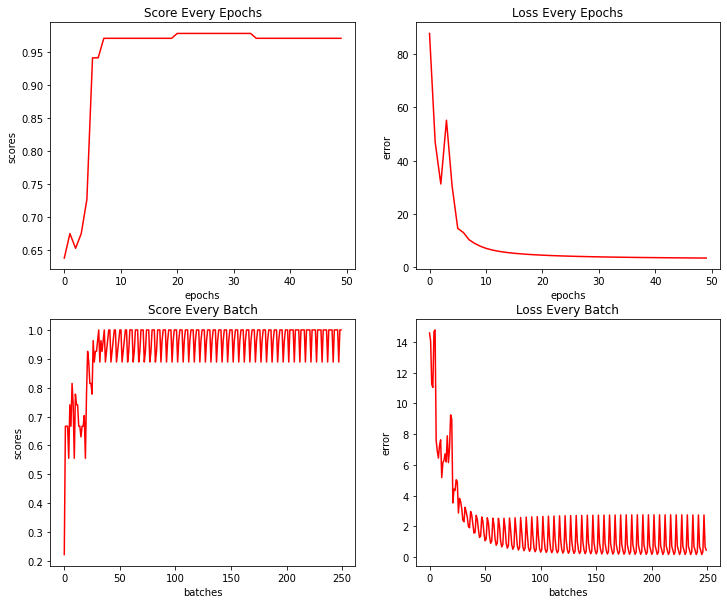

In [ ]:
model.plot()

## Testing skema 10-fold cross validation

In [ ]:
# Current KFold = 10
k = 10

cross_val_model = ANNClassifier()
cross_val_model.add(4, input_dim=x.shape[1], activation_function=sigmoid)
cross_val_model.add(3, activation_function=softmax)

results = cross_validation(X_train, y_train, cross_val_model, learning_rate=0.1,
                           loss=cross_entropy, batch_size=5, n_splits=k)
best_model = results["best_model"]

Epochs 1, loss = 53.63295648, score = 0.50413223
Epochs 2, loss = 37.84947105, score = 0.66115702
Epochs 3, loss = 25.87650624, score = 0.77685950
Epochs 4, loss = 22.55948481, score = 0.80165289
Epochs 5, loss = 20.88710160, score = 0.81818182
Epochs 6, loss = 17.82381754, score = 0.85123967
Epochs 7, loss = 14.35291546, score = 0.87603306
Epochs 8, loss = 11.78059139, score = 0.91735537
Epochs 9, loss = 10.01386613, score = 0.95041322
Epochs 10, loss = 8.71074462, score = 0.96694215
Epochs 11, loss = 7.72726516, score = 0.96694215
Epochs 12, loss = 6.98576160, score = 0.96694215
Epochs 13, loss = 6.42137810, score = 0.96694215
Epochs 14, loss = 5.98306337, score = 0.96694215
Epochs 15, loss = 5.63498827, score = 0.96694215
Epochs 16, loss = 5.35294771, score = 0.96694215
Epochs 17, loss = 5.12047447, score = 0.96694215
Epochs 18, loss = 4.92610828, score = 0.96694215
Epochs 19, loss = 4.76165684, score = 0.96694215
Epochs 20, loss = 4.62110464, score = 0.96694215
Epochs 21, loss = 4.

In [ ]:
for i, res in enumerate(results["score"]):
  print(f"KFold : {i+1} : {res}")
print(f"Average Accuracy with {len(results['score'])} KFold : {sum(results['score']) / len(results['score'])}")

KFold : 1 : 1.0
KFold : 2 : 1.0
KFold : 3 : 0.9285714285714286
KFold : 4 : 1.0
KFold : 5 : 0.9285714285714286
KFold : 6 : 0.8461538461538461
KFold : 7 : 0.9230769230769231
KFold : 8 : 1.0
KFold : 9 : 1.0
KFold : 10 : 0.9230769230769231
Average Accuracy with 10 KFold : 0.9549450549450551


In [ ]:
y_pred = best_model.predict(X_test)
accuracy_score(y_pred, y_test)

1.0

In [ ]:
confusion_matrix(y_pred, y_test)

array([[6, 0, 0],
       [0, 6, 0],
       [0, 0, 3]])

In [ ]:
classification_report(y_pred, y_test)

,precision,recall,f1-score
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0


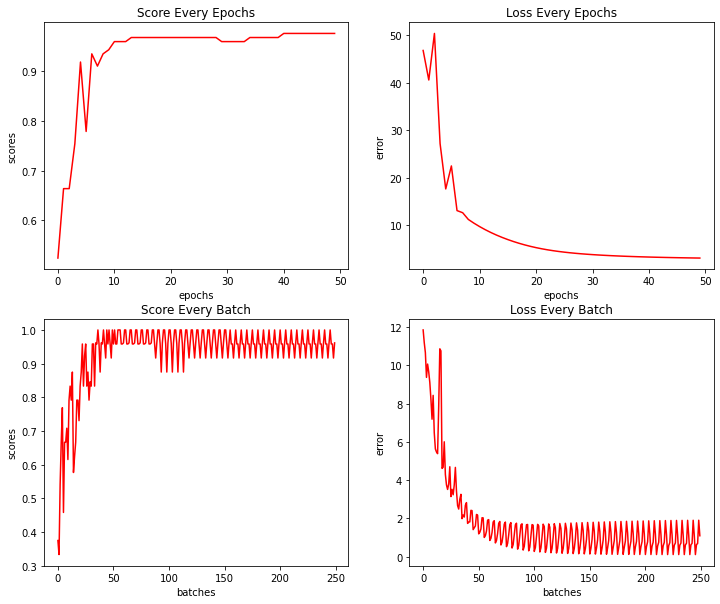

In [ ]:
best_model.plot()

# Save & Load Model 
---
Testing save and load model with **new instance** testing

In [ ]:
# Save model
best_model.save("model.json")

In [ ]:
# Load model
new_model = ANNClassifier()
new_model.load('model.json')

# predict same data
y_new_pred = new_model.predict(x_new)

In [ ]:
# Finding the average of each instance ... 
iris_dataset = load_iris()
x = iris_dataset['data']
y = iris_dataset['target']

mask = (y == 0)
instance0 = x[mask]

mask = (y == 1)
instance1 = x[mask]

mask = (y == 2)
instance2 = x[mask]

dataset = [instance0, instance1, instance2]

# Random instance : Using the same distribution with the current data
new_data = np.array([
    [np.median(data[:,0]), 
     np.median(data[:,1]), 
     np.median(data[:,2]), 
     np.median(data[:,3])]
    for data in dataset])

new_target = np.array([0,1,2])
b_new = one_hot_encoder(new_target)

In [ ]:
# Scaling (Use training data scaler)
x_new = scale.transform(new_data)

In [ ]:
# Showing results from current model
y_new_pred = new_model.predict(x_new)

# Summary ...
print(f"Accuracy for new instance : {accuracy_score(y_new_pred, b_new)}")
print("Confusion Matrix : ")
print(confusion_matrix(y_new_pred, b_new))

Accuracy for new instance : 1.0
Confusion Matrix : 
[[1 0 0]
 [0 1 0]
 [0 0 1]]


# Comparation with Library

## Perbandingan hasil dengan library MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix as confusion_sklearn

mlp_clf = MLPClassifier(random_state=42, hidden_layer_sizes=(4,), solver='sgd', activation='logistic',
                      alpha=0, batch_size=5, learning_rate_init=0.5, power_t=0, 
                      max_iter=50, shuffle=False, verbose=True, momentum=0,
                      beta_1=0, beta_2=0, n_iter_no_change=50)

In [ ]:
mlp_pred = mlp_clf.fit(X_train, y_train).predict(X_test)
custom_model_pred = new_model.predict(X_test)

Iteration 1, loss = 1.83812509
Iteration 2, loss = 1.27235377
Iteration 3, loss = 1.04302236
Iteration 4, loss = 0.92965346
Iteration 5, loss = 0.82833816
Iteration 6, loss = 0.72990132
Iteration 7, loss = 0.63654063
Iteration 8, loss = 0.55138184
Iteration 9, loss = 0.47757821
Iteration 10, loss = 0.41622720
Iteration 11, loss = 0.36643083
Iteration 12, loss = 0.32638813
Iteration 13, loss = 0.29420857
Iteration 14, loss = 0.26825096
Iteration 15, loss = 0.24718750
Iteration 16, loss = 0.22997057
Iteration 17, loss = 0.21578203
Iteration 18, loss = 0.20398663
Iteration 19, loss = 0.19409264
Iteration 20, loss = 0.18571974
Iteration 21, loss = 0.17857317
Iteration 22, loss = 0.17242364
Iteration 23, loss = 0.16709178
Iteration 24, loss = 0.16243634
Iteration 25, loss = 0.15834524
Iteration 26, loss = 0.15472885
Iteration 27, loss = 0.15151488
Iteration 28, loss = 0.14864458
Iteration 29, loss = 0.14606977
Iteration 30, loss = 0.14375069
Iteration 31, loss = 0.14165424
Iteration 32, los

In [ ]:
classification_report(mlp_pred, y_test)

,precision,recall,f1-score
0,1.000,1.00,1.000
1,0.833,1.00,0.909
2,1.000,0.75,0.857


In [ ]:
classification_report(custom_model_pred, y_test)

,precision,recall,f1-score
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0


In [ ]:
print(f'MLPClassifier = {accuracy_score(mlp_pred, y_test)}')
print(f'Our Implementation = {accuracy_score(custom_model_pred, y_test)}')

MLPClassifier = 0.9333333333333333
Our Implementation = 1.0


## Perbandingan confusion matrix dengan library

In [ ]:
# Custom Confusion Matrix
confusion_matrix(mlp_pred, y_test)

array([[6, 0, 0],
       [0, 5, 0],
       [0, 1, 3]])

In [ ]:
# Confusion matrix from sklearn
confusion_sklearn(mlp_pred.argmax(1), y_test.argmax(1))

array([[6, 0, 0],
       [0, 5, 0],
       [0, 1, 3]])

Berdasarkan uji coba, implementasi confusion matrix yang kami buat dengan apa yang dimiliki oleh library scikit-learn, memiliki output yang sama 

# Laporan
## A. Perbandingan FFNN dengan skema 90% train 10% test dan skema 10-fold cross validation

Jika dilihat dari confusion matrix kedua skema, skema 90% train dan 10% test (model 1) lebih buruk daripada skema 10-fold cross validation (model 2). Perbedaan ini terdapat model 1 saat memprediksi sebuah instance salah memprediksi kelas.

Berikut adalah score dari ***precision***, ***recall***, F1 dan akurasi dari Model 1:

| Category \ Class | 0     | 1     | 2   | 
|:-------------:   |:----: | :---: | :-: |
| Precision (%)    |   100 | 83,33 | 100 | 
| Recall (%)       |   100 | 100   | 75  |
|   F1 (%)         |   100 | 90.9  | 85.7|
| Akurasi (%)      |       | 93.3  |     |

Berikut adalah score dari ***precision***, ***recall***, F1 dan akurasi dari Model 2:

| Category \ Class | 0     | 1   | 2   | 
|:-------------:   |:----: | :-: | :-: |
| Precision (%)    |   100 | 100 | 100 | 
| Recall (%)       |   100 | 100 | 100 |
|   F1 (%)         |   100 | 100 | 100 |
| Akurasi (%)      |       | 100 |     |

Berdasarkan nilai score baik akurasi, *precision*, *recall*, maupun *f1*, model 2 lebih baik karena model 2 mendapatkan *perfect score* disetiap kelas.

Score dan error setiap *epoch* menunjukkan bahwa model 2 lebih stabil karena lebih konsisten perubahannya. 
Sedangkan score dan error setiap *batch*nya pada model 2, walaupun tidak semulus pada score dan error per *epoch*, tetapi model 2 lebih mulus daripada model 1.
Untuk error (baik per epoch ataupun per batch), model 2 memiliki maksimal error yang lebih kecil daripada model 1.

--- 


## B. Pembagian Kerja

| NIM      | Anggota                        | Pembagian Tugas           |
|----------|--------------------------------|---------------------------|
| 13518024 | Jovan Karuna Cahyadi           | - Membuat precision, recall, dan f1-score <br> - Membuat classification report|
| 13518062 | Ricky Fernando                 | - Membuat analisis <br> - Membantu mengerjakan confusion matrix  |
| 13518122 | Stefanus Stanley Yoga Setiawan | - Membuat confusion matrix <br> - Membuat plotting historical loss dan score train pada model <br> - Review code dan analisis yang sudah dibuat |
| 13518138 | William                        | - Melakukan pembelajaran FFNN untuk dataset iris dengan skema 10-fold cross validation (beserta kinerjanya) <br> - Melakukan uji coba penyimpanan model / hipotesis pembelajaran skema full training ke file eksternal <br> - Melakukan tahapan loading model / hipotesis dari file eksternal <br> - Membuat instance baru dan memprediksi dengan memanfaatkan model / hipotesis dari penyimpanan model pembelajaran utuh |

